In [1]:
%pip install -q numpy opencv-python torch tensorflow matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
# data -> [car, bus, truck]
from os import listdir
from os.path import join, dirname, abspath
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_and_preprocess(path, preprocess_callback):
    folders = [join(path, folder) for folder in listdir(path)]
    X, y = [], []
    for label, folder in enumerate(folders):
        files = [join(folder, f) for f in listdir(folder)]
        files = [cv2.imread(f) for f in files]
        files = [preprocess_callback(f) for f in files]
        X.extend(files)
        y.extend([label] * len(files))
    return np.array(X), np.array(y)

def preprocess_image(image):
    resized = cv2.resize(image, (224, 224)) # interpolation=cv2.INTER_AREA
    if len(image.shape) == 3:
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    else:
        gray = resized
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # histed = cv2.equalizeHist(gray)
    # th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    edge = cv2.Canny(gray, 100, 200)
    normalized = cv2.normalize(edge, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return normalized

path = join('../data/raw/')
X, y = load_images_and_preprocess(path, preprocess_image)
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=104, test_size=0.3, shuffle=True)

In [18]:
folders = [join(path, folder) for folder in listdir(path)]
folders

['../data/raw/Bus', '../data/raw/Car', '../data/raw/Truck']

In [8]:
import tensorflow as tf

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32)  # Adjust batch size if needed
test_dataset = test_dataset.batch(32)

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

size = (224, 224, 1)

# Model architecture
model = Sequential([
    # Input layer rather that input_shape
    Input(shape=size, name="vehicle"),

    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer to prevent overfitting
    # 30% of neuron is dropped (not contributing to forward/backward propagation)
    Dropout(0.3),

    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3), # Another dropout layer

    # Flatten and fully connected layers
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5), # Higher dropout before final dense
    Dense(units=3, activation='softmax')
])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,203 (91.20 MB)

 Trainable params: 23,907,203 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('model', model)
    ]
)

# result = pipeline.fit(X_train, y_train)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10  # Adjust the number of epochs
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3232 - loss: 4.6602 - val_accuracy: 0.3333 - val_loss: 1.4432
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3762 - loss: 1.8878 - val_accuracy: 0.3222 - val_loss: 1.0926
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4445 - loss: 1.0371 - val_accuracy: 0.4444 - val_loss: 1.0947
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5071 - loss: 1.0513 - val_accuracy: 0.4222 - val_loss: 1.0933
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6641 - loss: 1.0419 - val_accuracy: 0.3333 - val_loss: 1.0816
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6854 - loss: 0.9847 - val_accuracy: 0.3778 - val_loss: 1.0558
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6955 - loss: 0.8633 - val_accuracy: 0.5222 - val_loss: 0.9790
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8067 - loss: 0.6445 - val_accuracy: 0.4667 - val_loss: 0.9954
Epoch 9/10

In [12]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.5245 - loss: 0.8861
Test Loss: 0.9053428769111633
Test Accuracy: 0.5333333611488342


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Get model predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Flatten true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Classification report
print(classification_report(y_true, y_pred_classes, digits=4))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
              precision    recall  f1-score   support

           0     0.7333    0.3333    0.4583        33
           1     0.6786    0.6333    0.6552        30
           2     0.3830    0.6667    0.4865        27

    accuracy                         0.5333        90
   macro avg     0.5983    0.5444    0.5333        90
weighted avg     0.6100    0.5333    0.5324        90



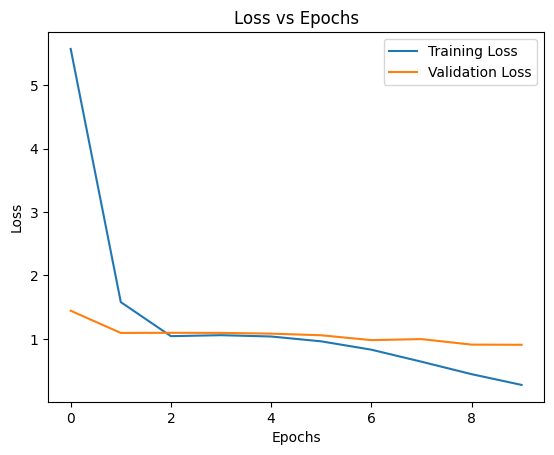

In [14]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


In [16]:
model.save('../models/vehicle_recognition.keras')